In [1]:
from spectrumtools.spectrum import Spectrum
from spectrumtools.generate_trapezoid_filter import generate_trapezoid_filter
from spectrumtools.analyze_waveform import plot_pulses, fit_tau, shape_waveform
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# Lab0.h5
# Source: Co-60


# invert pulses false, 500 trigger delay, 170 trigger threshold
f_name = 'data/Co60_jacob.h5'


f_data = h5py.File(f_name,'r')
raw_pulse_data = f_data['raw_data'][()]
raw_pulse_data = np.int16(raw_pulse_data) 
source_energies = [1173.228, 1332.492]

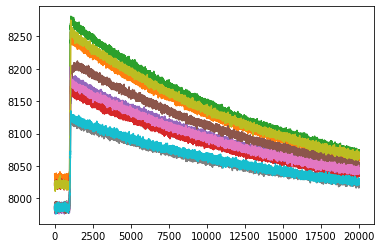

In [3]:
plot_pulses(raw_pulse_data, 10)

Fitted Decay Constant Tau: 16367.496209514791


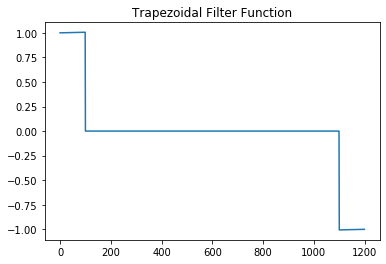

In [4]:
tau = fit_tau(raw_pulse_data[0])
print("Fitted Decay Constant Tau: {0}".format(tau))
k = 100
l = 1000
pre_trigger_delay = 1000

trap_filter = generate_trapezoid_filter(tau, k, l)
plt.figure()
plt.plot(trap_filter)
plt.title("Trapezoidal Filter Function")
plt.show()

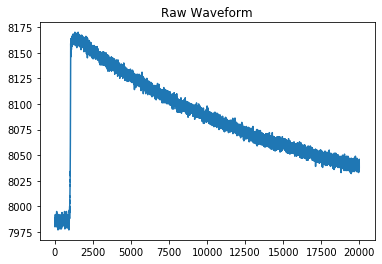

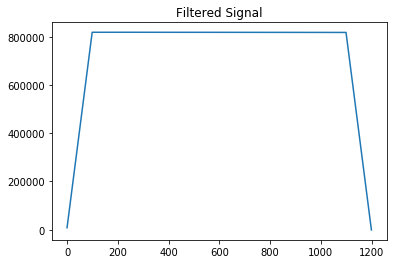

In [5]:
plt.figure()
plt.plot(raw_pulse_data[0])
plt.title("Raw Waveform")
plt.show()


integral, filtered_signal = shape_waveform(raw_pulse_data[0], trap_filter, k, pre_trigger_delay)

plt.figure()
plt.plot(filtered_signal)
plt.title("Filtered Signal")
plt.show()

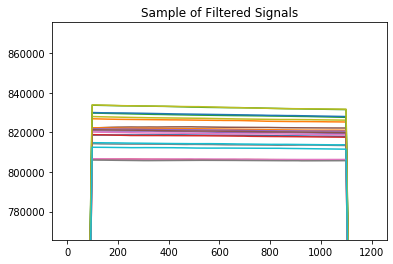

In [7]:

num_pulses = len(raw_pulse_data)
trapezoid_heights = np.zeros(num_pulses)

plt.figure()
for i in range( num_pulses ):
    trapezoid_heights[i], signal = shape_waveform(raw_pulse_data[i], trap_filter, k, pre_trigger_delay)
    if i < 20:
        plt.plot(signal)

plt.title("Sample of Filtered Signals")
plt.ylim((0.95*min(trapezoid_heights[:20]), 1.05*max(trapezoid_heights[:20])))
plt.show()

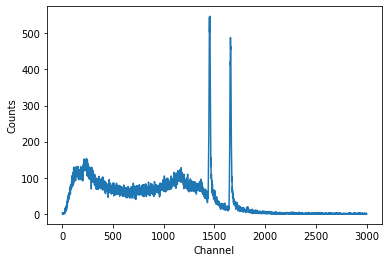

In [24]:
# Discard 0 valued pulses (waveform was anomalous)
spectrum_start = np.min(trapezoid_heights)
# Ignore high outliers above 99.9th percentile (mostly noise)
spectrum_end = np.quantile(trapezoid_heights, 0.999)

number_of_bins = 3000

counts, bins = np.histogram(trapezoid_heights,
                            bins=number_of_bins, 
                            range=[spectrum_start, spectrum_end])
channels = np.arange(1, 1+len(counts))

plt.plot(channels, counts)
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.show()

In [18]:
binned_spectrum = Spectrum(counts)
binned_spectrum.calibrate( source_energies, auto_calibrate=True , reset_calibration = True )

Energy(c) = -0.0c^2 + 0.8265c + 0.0


array([-1.34852819e-05,  8.26504436e-01,  1.33586920e-13])

In [25]:
binned_spectrum.show_histogram("Calibrated Spectrum")